In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scikit-plot  # Correct the package name
import scikitplot

In [4]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Data Loading

In [5]:
data = pd.read_csv("/content/drive/MyDrive/CodeClause/Facial Recognition Project/fer2013.csv")
data.shape

(35887, 3)

In [6]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


#Data Pre-Processing

In [8]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] ,
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [9]:
data = data.sample(frac=1)

In [10]:
labels = to_categorical(data[['emotion']], num_classes=7)

In [11]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

In [12]:
pixels = train_pixels.reshape((35887*2304,1))

In [13]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [14]:
pixels = train_pixels.reshape((35887, 48, 48,1))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


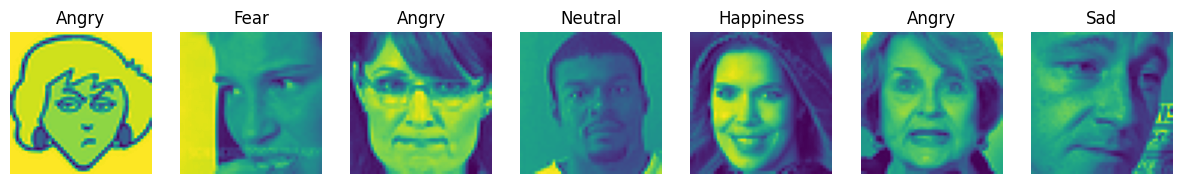

In [17]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [18]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [19]:
datagen.fit(X_train)
valgen.fit(X_val)

In [20]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

#Model Desining

In [21]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

In [22]:
model = cnn_model()

In [23]:
model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [25]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [26]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 6.7562 - accuracy: 0.2348
Epoch 1: val_accuracy improved from -inf to 0.16006, saving model to best_model.h5
455/455 [==============================] - 41s 60ms/step - loss: 6.7562 - accuracy: 0.2348 - val_loss: 3.5079 - val_accuracy: 0.1601
Epoch 2/30
454/455 [============================>.] - ETA: 0s - loss: 2.6568 - accuracy: 0.3060
Epoch 2: val_accuracy improved from 0.16006 to 0.26378, saving model to best_model.h5
455/455 [==============================] - 26s 57ms/step - loss: 2.6561 - accuracy: 0.3061 - val_loss: 2.6952 - val_accuracy: 0.2638
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 2.6320 - accuracy: 0.3866
Epoch 3: val_accuracy improved from 0.26378 to 0.30186, saving model to best_model.h5
455/455 [==============================] - 26s 57ms/step - loss: 2.6326 - accuracy: 0.3865 - val_loss: 2.9488 - val_accuracy: 0.3019
Epoch 4/30
455/455 [==============================] - ETA:

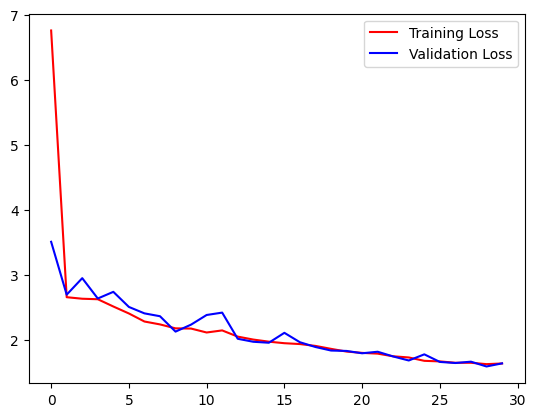

In [27]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

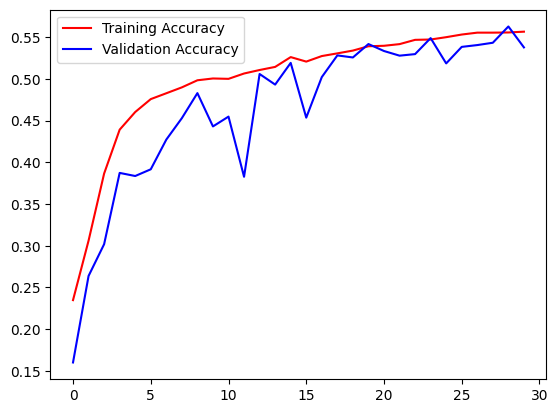

In [28]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [29]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 3s 14ms/step - loss: 1.5806 - accuracy: 0.5592
Test Acc: 0.5592086911201477


In [30]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 6ms/step


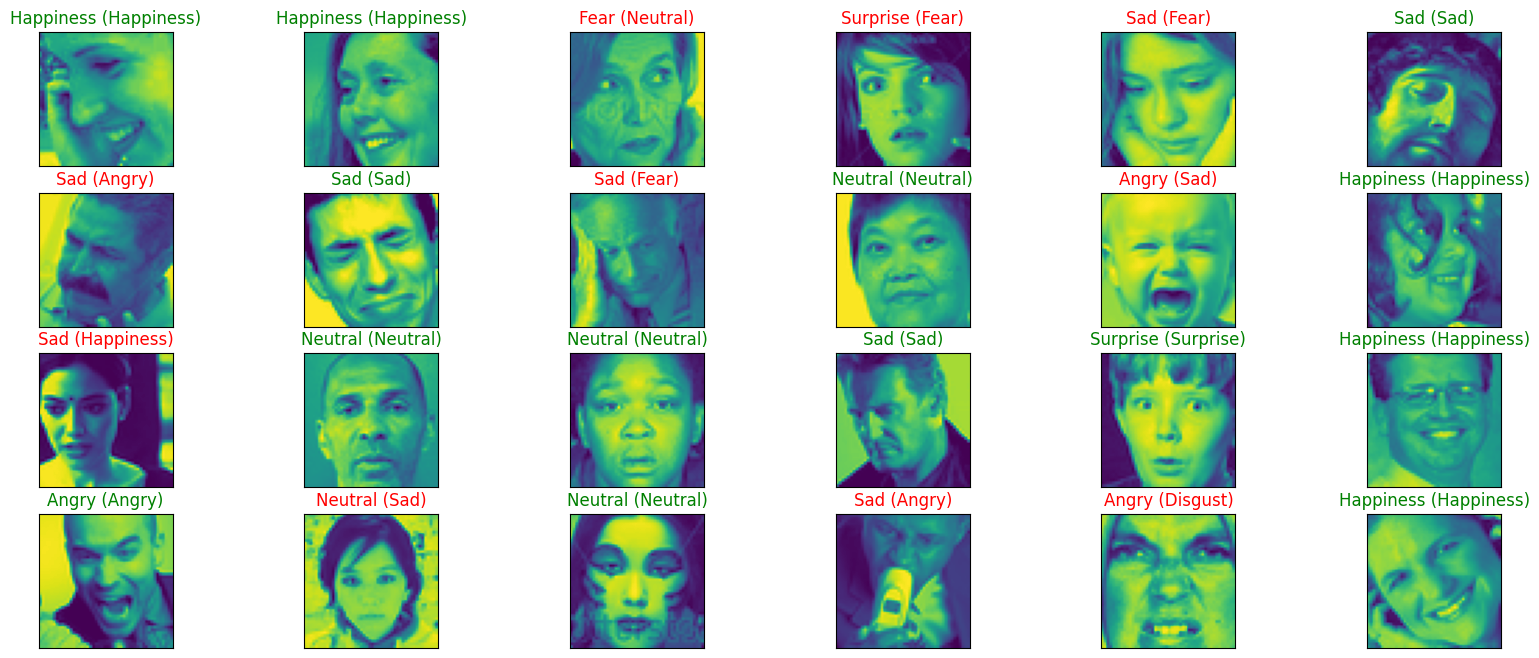

In [31]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

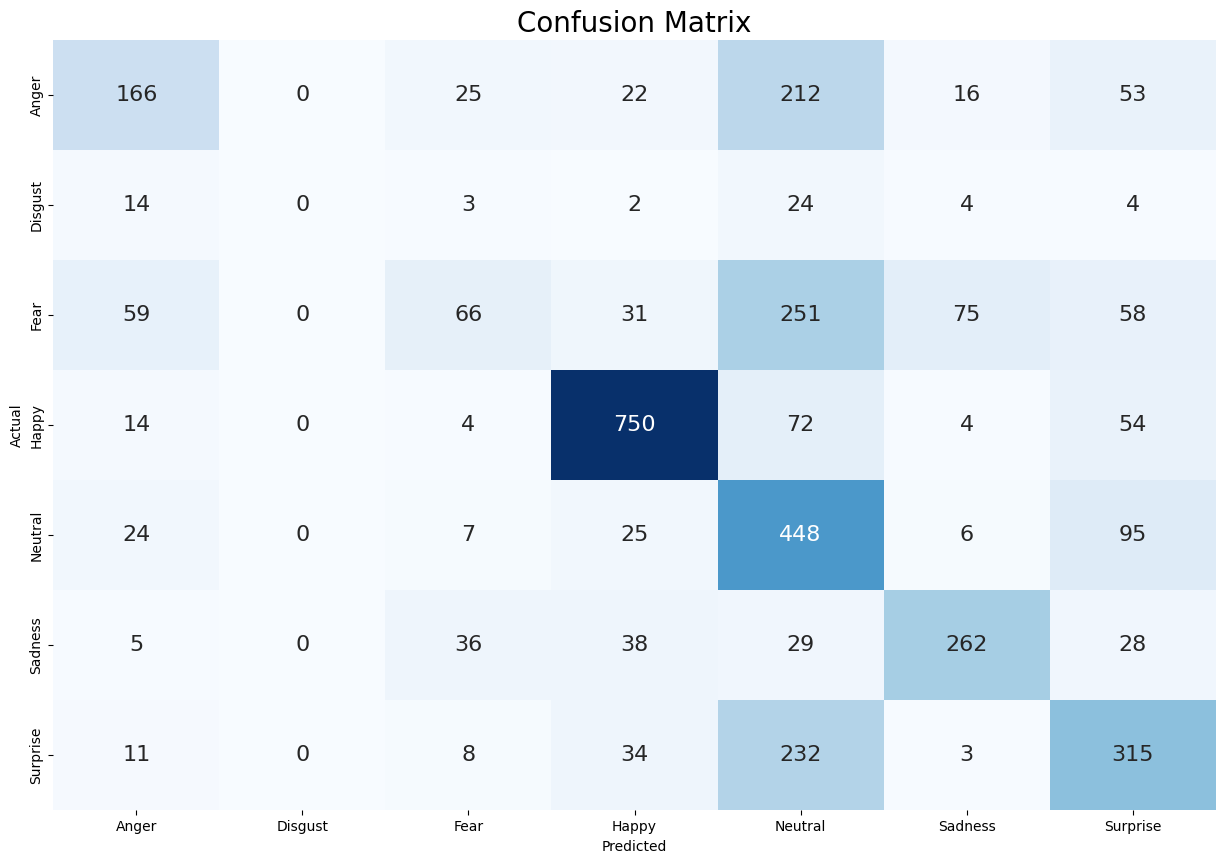

In [32]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [33]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.567     0.336     0.422       494
           1      0.000     0.000     0.000        51
           2      0.443     0.122     0.192       540
           3      0.831     0.835     0.833       898
           4      0.353     0.740     0.478       605
           5      0.708     0.658     0.682       398
           6      0.519     0.522     0.521       603

    accuracy                          0.559      3589
   macro avg      0.489     0.459     0.447      3589
weighted avg      0.578     0.559     0.539      3589



In [34]:
model = cnn_model()

In [35]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [36]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.8448 - accuracy: 0.1659
Epoch 1: val_accuracy did not improve from 0.56285
455/455 [==============================] - 36s 65ms/step - loss: 14.8448 - accuracy: 0.1659 - val_loss: 14.0837 - val_accuracy: 0.1833
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 14.4131 - accuracy: 0.1746
Epoch 2: val_accuracy did not improve from 0.56285
455/455 [==============================] - 24s 53ms/step - loss: 14.4131 - accuracy: 0.1746 - val_loss: 13.7799 - val_accuracy: 0.2201
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 14.0639 - accuracy: 0.1841
Epoch 3: val_accuracy did not improve from 0.56285
455/455 [==============================] - 25s 54ms/step - loss: 14.0639 - accuracy: 0.1841 - val_loss: 13.5533 - val_accuracy: 0.2517
Epoch 4/30
454/455 [============================>.] - ETA: 0s - loss: 13.7738 - accuracy: 0.1960
Epoch 4: val_accuracy did not improve from 0.56285
455

In [37]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 11ms/step - loss: 12.0678 - accuracy: 0.2703
Test Acc: 0.2702702581882477


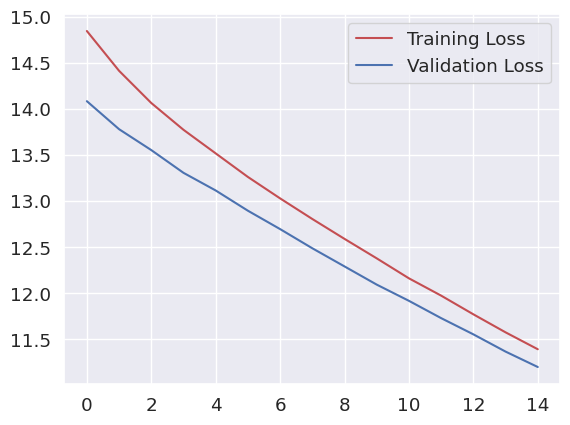

In [38]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

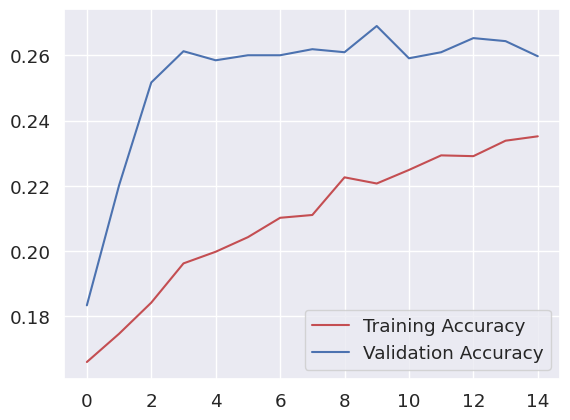

In [39]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [40]:
model = cnn_model()

In [41]:
model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [42]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [43]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
455/455 [==============================] - ETA: 0s - loss: 6.7340 - accuracy: 0.2244
Epoch 1: val_accuracy improved from -inf to 0.25542, saving model to best_model.h5
455/455 [==============================] - 32s 58ms/step - loss: 6.7340 - accuracy: 0.2244 - val_loss: 2.8013 - val_accuracy: 0.2554
Epoch 2/50
454/455 [============================>.] - ETA: 0s - loss: 2.6716 - accuracy: 0.2948
Epoch 2: val_accuracy improved from 0.25542 to 0.33158, saving model to best_model.h5
455/455 [==============================] - 26s 58ms/step - loss: 2.6717 - accuracy: 0.2950 - val_loss: 2.6818 - val_accuracy: 0.3316
Epoch 3/50
455/455 [==============================] - ETA: 0s - loss: 2.7702 - accuracy: 0.3717
Epoch 3: val_accuracy improved from 0.33158 to 0.38328, saving model to best_model.h5
455/455 [==============================] - 25s 55ms/step - loss: 2.7702 - accuracy: 0.3717 - val_loss: 2.8019 - val_accuracy: 0.3833
Epoch 4/50
454/455 [============================>.] - ETA:

In [44]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 3s 15ms/step - loss: 1.4129 - accuracy: 0.5882
Test Acc: 0.5881861448287964


In [45]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 9ms/step


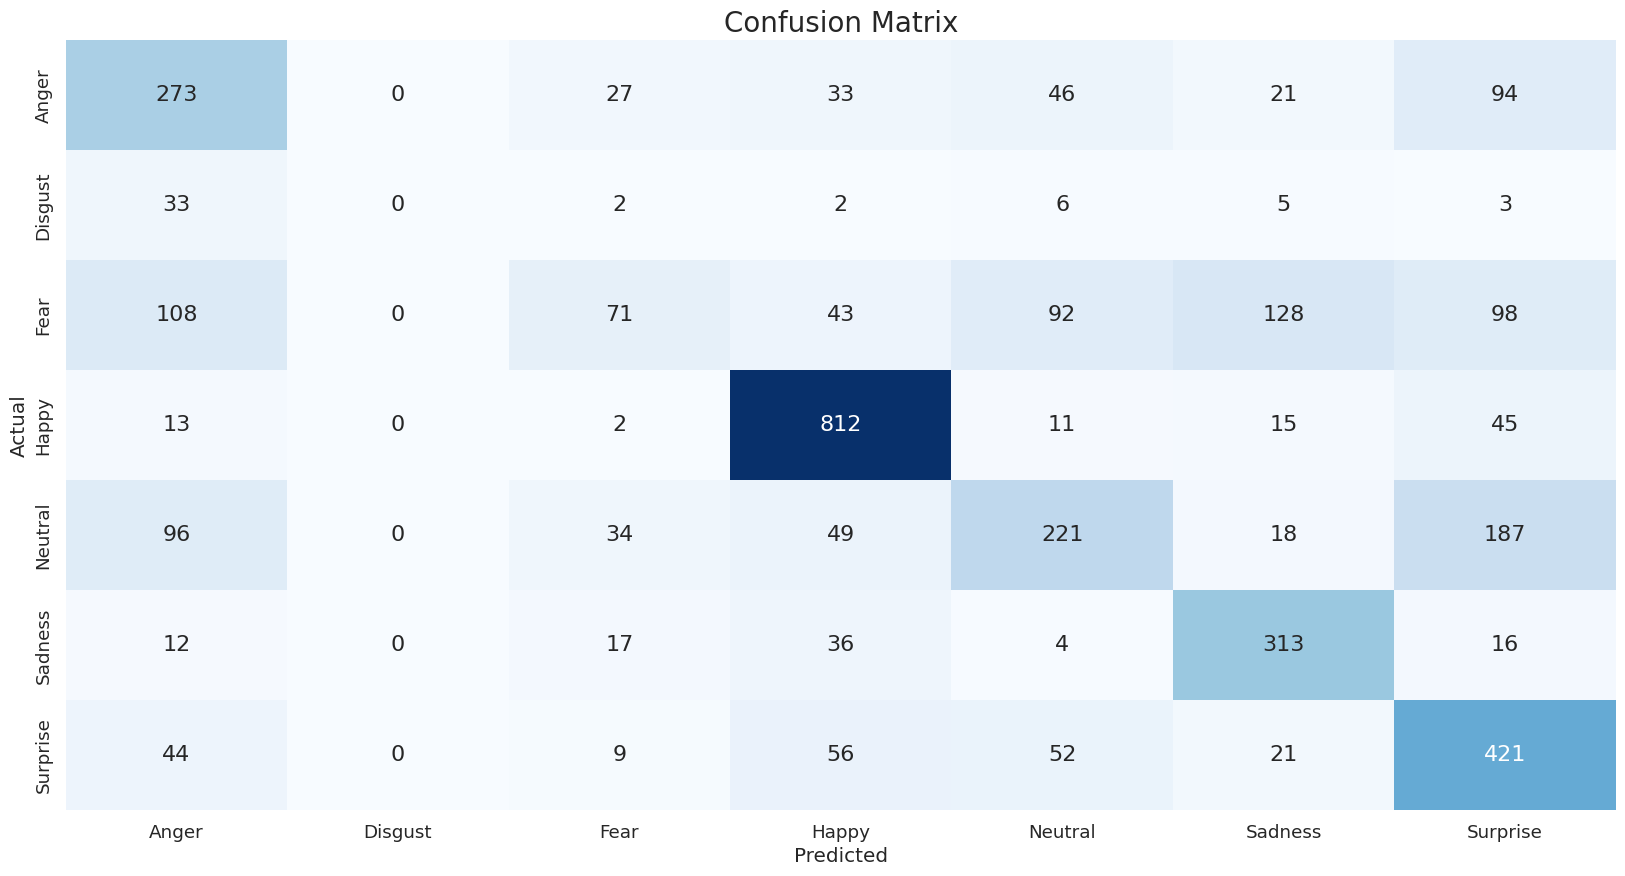

In [46]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [47]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.472     0.553     0.509       494
           1      0.000     0.000     0.000        51
           2      0.438     0.131     0.202       540
           3      0.788     0.904     0.842       898
           4      0.512     0.365     0.426       605
           5      0.601     0.786     0.681       398
           6      0.487     0.698     0.574       603

    accuracy                          0.588      3589
   macro avg      0.471     0.491     0.462      3589
weighted avg      0.563     0.588     0.555      3589

